# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import numba 
from matplotlib import rc

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
strains =['ps4187', 'ps4087', 'ps4176']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [3]:
q = 0.1

In [4]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../input/quantifications.csv')

tidy = tidy[tidy.strain.isin(strains)]

In [5]:
overlap4087 = epi.find_overlap(['ps4087', 'ps4176'], tidy)
overlap4187 = epi.find_overlap(['ps4187', 'ps4176'], tidy)

sy622_associated = tidy[(tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187))].target_id.unique()
bx93_associated = tidy[(tidy.target_id.isin(overlap4187))].target_id.unique()
sy622_specific = tidy[(~tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187)) & (tidy.qval < q) & (tidy.strain == 'ps4087')].target_id.unique()
transhet_specific = tidy[(~tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187)) & (tidy.qval < q) & (tidy.strain == 'ps4176')].target_id.unique()


classes = {'sy622 associated': sy622_associated,
           'bx93 associated': bx93_associated,
           'sy622 specific': sy622_specific,
           'transhet specific': transhet_specific}

In [6]:
inv_classes = {}

for key, value in classes.items():
    n = len(tidy[tidy.target_id.isin(value)].ens_gene.unique())
    print(key, n)
    
    for v in value:
        inv_classes[v] = key

sy622 associated 989
bx93 associated 310
sy622 specific 1623
transhet specific 1676


In [7]:
tidy['phenotypic class'] = tidy.target_id.map(inv_classes)

bx93 associated mean: 1.3, median: 0.96
bx93 associated 95 percentile: 4.2
sy622 associated mean: 0.99, median: 0.55
sy622 associated 95 percentile: 3.3
sy622 specific mean: 0.9, median: 0.56
sy622 specific 95 percentile: 3


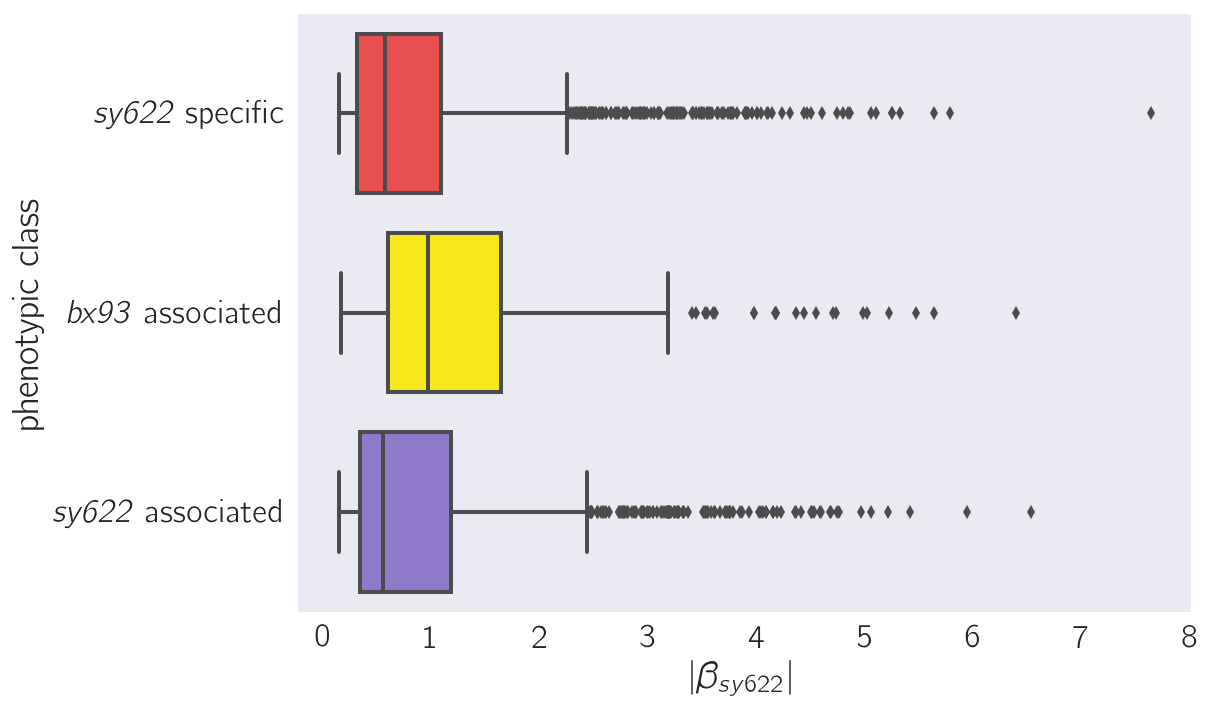

In [8]:
temp = tidy[(tidy.qval < q) & (tidy.strain == 'ps4087')].dropna().copy()
temp.b = temp.b.abs()
sns.boxplot(y='phenotypic class', x='b', data=temp)
plt.xlabel(r'$|\beta_{sy622}|$')
plt.gca().set_yticklabels([r'\emph{sy622} specific', r'\emph{bx93} associated', r'\emph{sy622} associated'])

plt.gca().artists[0].set_facecolor('#E85050')
plt.gca().artists[1].set_facecolor('#F7E71D')
plt.gca().artists[2].set_facecolor('#8F79CA')
plt.savefig('../output/beta_values_phenotypic_classes_sy622.svg', bbox_inches='tight')

grouped = temp.groupby('phenotypic class')
for name, group in grouped:
    print("{0} mean: {1:.2g}, median: {2:.2g}".format(name, group.b.mean(), np.median(group.b)))
    print("{0} 95 percentile: {1:.2g}".format(name, group.b.quantile(.95)))

In [9]:
@numba.jit(nopython=True)
def bootstrap_difference_of_means(x, y, n=10**4):
    """Given two datasets, return a pvalue for null H (means are the same)."""
    nx = len(x)
    ny = len(y)

    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y
    
    delta = np.zeros(n)

    for i in np.arange(n):
        nullx = np.random.choice(mixed, nx, replace=True)
        nully = np.random.choice(mixed, ny, replace=True)
        diff = nully.mean() - nullx.mean()
        delta[i] = diff

    return delta

pvalue is 0.00


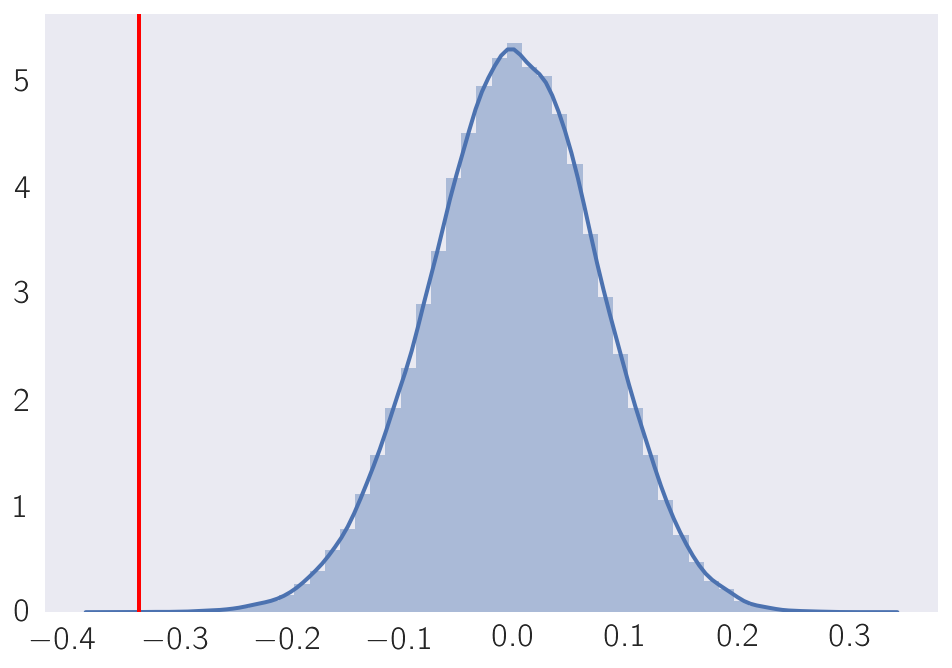

In [10]:
x = temp[temp['phenotypic class'] == 'bx93 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 associated'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

pvalue is 0.00


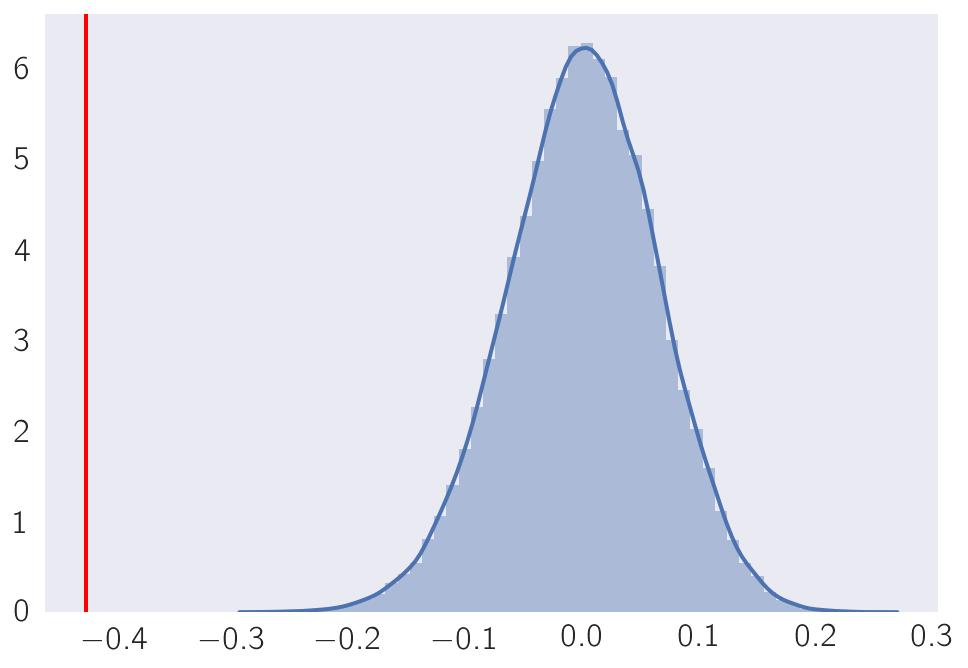

In [11]:
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

pvalue is 0.01


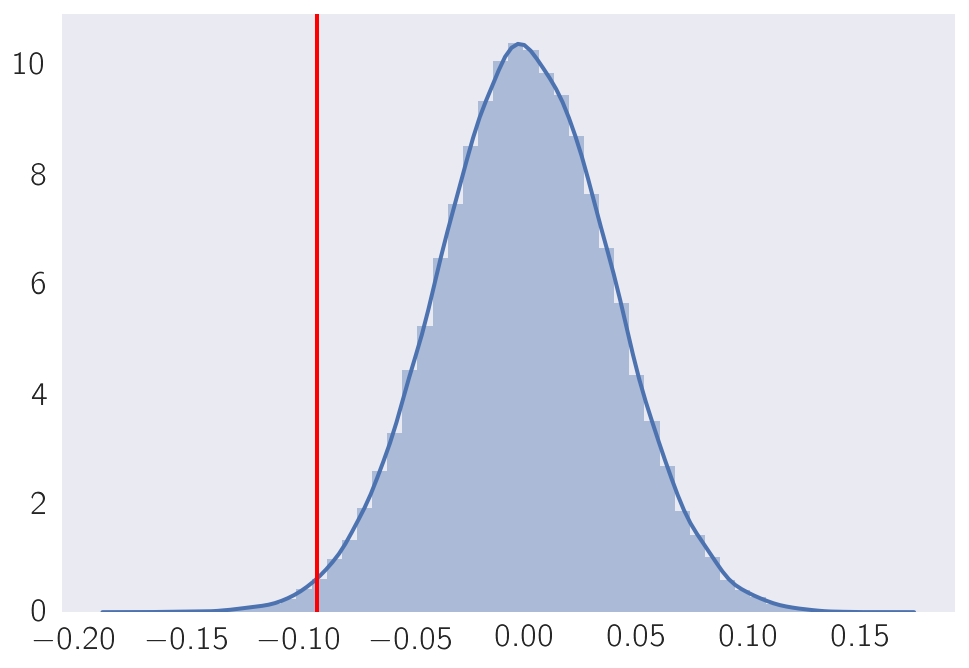

In [12]:
x = temp[temp['phenotypic class'] == 'sy622 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

In [13]:
tidy.drop(['Unnamed: 0', 'absb', 'order'], axis=1).to_csv('../output/dpy_22_results.csv')

In [14]:
import tissue_enrichment_analysis as ea

In [15]:
tissue = ea.fetch_dictionary('tissue')
pheno = ea.fetch_dictionary('phenotype')
go = ea.fetch_dictionary('go')

In [16]:
tissues = {}
phenos = {}
gos = {}
for key, value in classes.items():
    ids = tidy[tidy.target_id.isin(value)].ens_gene.unique()
    tissues[key] = ea.enrichment_analysis(ids, tissue, show=False)
    phenos[key] = ea.enrichment_analysis(ids, pheno, show=False)
    gos[key] = ea.enrichment_analysis(ids, go, show=False)

In [17]:
for key, t in tissues.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 associated
                                           Tissue   Expected  Observed  \
254                          Nucleus WBbt:0006803  44.939499        89   
10                     gon herm sujn WBbt:0008210  44.448357        89   
33   spermathecal-uterine valve cell WBbt:0008217  45.676212        90   
63     spermathecal-uterine junction WBbt:0006756  48.193315        91   
252                            Psub1 WBbt:0006874  14.304513        33   
193                    somatic gonad WBbt:0005785  75.881448       115   
99              cephalic sheath cell WBbt:0008406  18.602006        37   

     Enrichment Fold Change       P value       Q value  
254                1.980440  4.044682e-10  6.408715e-08  
10                 2.002324  2.305293e-10  6.408715e-08  
33                 1.970391  4.240810e-10  6.408715e-08  
63                 1.888229  2.963020e-09  2.059299e-07  
252                2.306964  2.650671e-06  1.473773e-04  
193                1.515522  4.793616e-06 

In [18]:
for key, t in phenos.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 associated
                                                Tissue   Expected  Observed  \
77   pleiotropic defects severe early emb WBPhenoty...   8.494119        21   
103  mitotic chromosome segregation variant WBPheno...   4.071561        13   
147  diplotene absent during oogenesis WBPhenotype:...   7.511329        18   
67                 progeny variant WBPhenotype:0000069  55.106477        81   
110                     no oocytes WBPhenotype:0000291  14.390863        27   
117  hermaphrodite fertility reduced WBPhenotype:00...  72.445712       100   
127                mitosis variant WBPhenotype:0001743  18.462425        32   
13   pachytene progression during oogenesis variant...  19.094219        32   

     Enrichment Fold Change   P value   Q value  
77                 2.472299  0.000034  0.007386  
103                3.192878  0.000037  0.007386  
147                2.396380  0.000157  0.011331  
67                 1.469882  0.000231  0.012450  
110                1.

In [19]:
for key, t in gos.items():
    if len(t) != 0:
        print(key)
        print(t[t['Enrichment Fold Change'] > 3.5])

sy622 associated
                                                Tissue   Expected  Observed  \
229                   developmental process GO:0032502  98.195721       345   
233                      embryo development GO:0009790  56.842875       237   
227                            reproduction GO:0000003  54.941197       231   
70               post-embryonic development GO:0009791  40.574887       164   
33          reproductive system development GO:0061458  17.443571        79   
169  development of primary sexual characteristics ...  17.184251        78   
143                  multi-organism process GO:0051704  13.363608        61   
249                   immune system process GO:0002376   5.929777        41   
199                              cell death GO:0008219  13.242592        50   
257              meiotic cell cycle process GO:1903046   6.465704        27   
116      posttranscriptional gene silencing GO:0016441   3.077260        18   
99                          collage